In [1]:
import csv
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#defining filedirectory
fileDir = os.path.dirname(os.path.realpath('__file__'))

In [3]:
#defining data frames
dfLoanData = pd.DataFrame()

In [4]:
#reading clean-data from csv
for directory, subdirectory, filenames in  os.walk(fileDir + '/CleanedData'):
    for filename in filenames:
        if filename == 'LoanData.csv':
            print("Reading from a file: " + filename + '....')
            dfLoanData = pd.read_csv(os.path.join(directory, filename), encoding = 'ISO-8859-1')

Reading from a file: LoanData.csv....


In [5]:
#creating copies of data frames
df = dfLoanData.copy()

In [6]:
columns = ['term', 'int_rate', 'grade', 'emp_length', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 
           'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_acc', 'acc_now_delinq', 
           'issue_year', 'cr_line_history', 'Credit_Score_Code', 
           'Last_Credit_Score_Code','loan_status_binary', 'home_ownership_binary', 'verification_status_binary', 
           'application_type_binary', 'loan_amnt_category_code', 'annual_inc_category_code']

In [7]:
df = df[columns]

In [8]:
df['grade'] = (df['grade']).astype('category')
df['purpose'] = (df['purpose']).astype('category')
df['addr_state'] = (df['addr_state']).astype('category')

In [9]:
#converting all the category columns to int by taking category-code
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

# STANDARDIZE THE DATA

In [10]:
# Get only the numeric columns from games.
clus_train = df._get_numeric_data()

# K-MEANS ANALYSIS - INITIAL CLUSTER SET

In [11]:
# k-means cluster analysis for 1-10 clusters due to the 10 possible class outcomes..
from scipy.spatial.distance import cdist
clusters=range(1,11)
meandist=[]

In [12]:
# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape
from sklearn.cluster import KMeans

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1))
    / clus_train.shape[0])

# Elbow Method to identify number of clusters

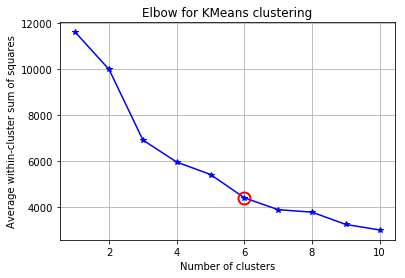

In [13]:
# Plot average distance from observations from the cluster centroid
# to use the Elbow Method to identify number of clusters to choose
import matplotlib.pylab as plt

kIdx = 5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(clusters, meandist, 'b*-')
ax.plot(clusters[kIdx], meandist[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

# Interpret 5 cluster solution

In [11]:
from sklearn.cluster import KMeans

model5=KMeans(n_clusters=5)
model5.fit(clus_train) # has cluster assingments based on using 3 clusters
clusassign=model5.predict(clus_train)

# Canonical Discriminant Analysis for variable reduction

In [15]:
# Canonical variables are ordered by proportion of variance accounted for
# most of the variance will be accounted for in the first few canonical variables
from sklearn.decomposition import PCA # CA from PCA function
pca_2 = PCA(2) # return 2 first canonical variables

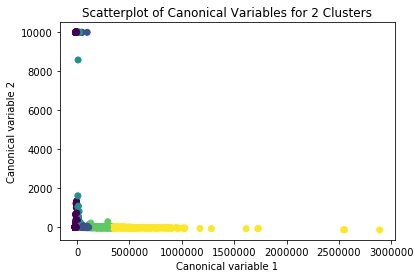

In [16]:
plot_columns = pca_2.fit_transform(clus_train) # fit CA to the train dataset
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model5.labels_,) # plot 1st canonical variable on x axis, 2nd on y-axis
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show() # close or overlapping clusters idicate correlated variables with low in-class variance but not good separation. 2 cluster might be better.

In [12]:
# create a unique identifier variable from the index for the
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)

In [13]:
# create a list that has the new index variable
cluslist=list(clus_train['index'])

In [14]:
# create a list of cluster assignments
labels=list(model5.labels_)

In [15]:
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))

In [16]:
# convert newlist dictionary to a dataframe
newclus=pd.DataFrame.from_dict(newlist, orient='index')

In [17]:
# rename the cluster assignment column
newclus.columns = ['cluster']

In [18]:
# cluster assignment dataframe to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

In [19]:
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')

In [20]:
clusteredLoansPath = fileDir+'/CleanedData/ClusteredLoans.csv'

In [21]:
#function to write the data in chunks
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [22]:
withHeaders = True
for i in chunker(merged_train,50000):
    if(withHeaders):
        i.to_csv(clusteredLoansPath, index=False, mode='a')
        withHeaders = False
    else:
        i.to_csv(clusteredLoansPath, index=False, mode='a', header = False)

In [27]:
# cluster frequencies
merged_train.cluster.value_counts()

0    952282
2    323967
1     36188
3      6076
4       585
Name: cluster, dtype: int64

In [32]:
aggregations = {
        'emp_length': {
            'avg_emp_len': 'mean'
        },
        'delinq_2yrs': {
            'avg_delinq_2yrs': 'mean'
        },
        'dti': {
            'avg_dti': 'mean'
        },
        'pub_rec': {
            'avg_pub_rec': 'mean'
        },
        'cr_line_history': {
            'avg_cr_line_history': 'mean'
        },
        'inq_last_6mths': {
            'avg_inq_last_6mths': 'mean'
        },
        'loan_amnt_category_code': {
            'most_likely_loan_amnt_cat': lambda x:x.value_counts().index[0]
        }
    }

In [33]:
# FINALLY calculate clustering variable means by cluster
del merged_train['index']
clustergrp = merged_train.groupby('cluster').agg(aggregations)
print ("Clustering variable means by cluster")
clustergrp

Clustering variable means by cluster


,emp_length,delinq_2yrs,dti,pub_rec,cr_line_history,inq_last_6mths,loan_amnt_category_code
,avg_emp_len,avg_delinq_2yrs,avg_dti,avg_pub_rec,avg_cr_line_history,avg_inq_last_6mths,most_likely_loan_amnt_cat
cluster,,,,,,,
0,5.500990,0.354263,17.952899,0.266999,15.335760,0.661412,0
1,6.802863,0.273350,22.362199,0.062396,22.268735,0.654554,9
2,6.434834,0.263261,21.189099,0.082657,18.962058,0.588245,8
3,6.872778,0.373766,20.666136,0.093318,24.049210,0.715932,9
4,6.895726,0.348718,20.248906,0.152137,25.261538,0.830769,9
